# Gymnasium RL

In [1]:
import gymnasium as gym

In [2]:
env = gym.make("CartPole-v1")

trajectory = []
state, _ = env.reset()
done = False
trunc = False
total_reward = 0.0

while not (done or trunc):
    action = env.action_space.sample()
    next_state, reward, done, trunc, _ = env.step(action)
    trajectory.append([state, action])
    total_reward += reward
    state = next_state

print("Total reward:", total_reward)
# trajectory[:10]


Total reward: 18.0


### Interacting with the environment

In [4]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
try:
    obs, _ = env.reset()

    over = False
    while not over:
        action = env.action_space.sample()
        obs, reward, done, trunc, _ = env.step(action)
        over = done or trunc
finally:
    env.close()

### Modifying the environment with Wrappers

In [5]:
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation

env = gym.make("CarRacing-v2")
env.observation_space.shape
wrapped_env = FlattenObservation(env)
wrapped_env.observation_space.shape

(27648,)

## Q-Learning Agent for Blackjack

### Construct the agent and the Blackjack env

In [6]:
from collections import defaultdict
import gymnasium as gym
import numpy as np

# Construct the agent with abilities to choose actions and update q_values
class BlackjackAgent:
    def __init__(self, env:gym.Env, lr: float, eps_init:float, eps_decay:float,
                 eps_final:float, dis_factor:float=0.95):
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = lr
        self.dis_factor = dis_factor
        self.eps = eps_init
        self.eps_decay = eps_decay
        self.eps_final = eps_final

        self.training_error = []
    
    def get_action(self, obs: tuple[int, int, bool]) -> int:
        if np.random.random() < self.eps: #explore
            return self.env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
    
    def td_update(self, obs: tuple[int, int, bool], action: int, reward: float, 
               terminated: bool, next_obs: tuple[int, int, bool]):
        next_max_q_value = (not terminated) * np.max(self.q_values[next_obs])
        td = reward + self.dis_factor* next_max_q_value - self.q_values[obs][action]
        self.q_values[obs][action] += self.lr * td
        self.training_error.append(td)
    
    def mc_update(self, trajectory: list[tuple[int, int, bool]], action_list: list, 
                  reward: list):
        for step in range(len(trajectory)):
            g_return = np.sum([self.dis_factor ** k * rew for k, rew in enumerate(reward[step:])])
            mc = g_return - self.q_values[trajectory[step]][action_list[step]]
            self.q_values[trajectory[step]][action_list[step]] += self.lr * mc
            self.training_error.append(mc)
    
    def decay_epsilon(self):
        self.eps = max(self.eps_final, self.eps - self.eps_decay)
    
lr = 0.01
n_episodes = 100_000
eps_init = 1.0
eps_decay = eps_init / (n_episodes / 2)
eps_final = 0.1

env = gym.make("Blackjack-v1", sab=False)
# env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

agent_td = BlackjackAgent(env, lr, eps_init, eps_decay, eps_final)
agent_mc = BlackjackAgent(env, lr, eps_init, eps_decay, eps_final)


### Train the agent

In [ ]:
from tqdm import tqdm

#This is training loop for the TD player
episodes_record_td = {"rewards": [], "lengths": []}
for episode in tqdm(range(n_episodes)):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    episode_len = 0

    while not done:
        action = agent_td.get_action(obs)
        next_obs, reward, term, trunc, _ = env.step(action)
        agent_td.td_update(obs, action, reward, term, next_obs)
        total_reward += reward
        episode_len += 1
        done = term or trunc
        obs = next_obs
    episodes_record_td["rewards"].append(total_reward)
    episodes_record_td["lengths"].append(episode_len)
    agent_td.decay_epsilon()

env.reset()

#This is training loop for the MC player
episodes_record_mc = {"rewards": [], "lengths": []}
for episode in tqdm(range(n_episodes)):
    obs, _ = env.reset()
    done = False
    episode_len = 0
    trajectory = []
    action_list = []
    reward_list = []

    while not done:
        action = agent_mc.get_action(obs)
        next_obs, reward, term, trunc, _ = env.step(action)
        trajectory.append(obs)
        action_list.append(action)
        reward_list.append(reward)
        episode_len += 1
        done = term or trunc
        obs = next_obs
    agent_mc.mc_update(trajectory, action_list, reward_list)
    episodes_record_mc["rewards"].append(np.sum(reward_list))
    episodes_record_mc["lengths"].append(episode_len)
    agent_td.decay_epsilon()

env.reset()

### Plot summary graph

In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(40, 16))

axs[0][0].plot(np.convolve(episodes_record_td["rewards"], np.ones(100)))
axs[0][0].set_title("TD Episode Rewards")
axs[0][0].set_xlabel("Episode")
axs[0][0].set_ylabel("Reward")

axs[0][1].plot(np.convolve(episodes_record_td["lengths"], np.ones(100)))
axs[0][1].set_title("TD Episode Lengths")
axs[0][1].set_xlabel("Episode")
axs[0][1].set_ylabel("Length")

axs[0][2].plot(np.convolve(agent_td.training_error, np.ones(100)))
axs[0][2].set_title("TD Training Error")
axs[0][2].set_xlabel("Episode")
axs[0][2].set_ylabel("TD Error")

axs[1][0].plot(np.convolve(episodes_record_mc["rewards"], np.ones(100)))
axs[1][0].set_title("MC Episode Rewards")
axs[1][0].set_xlabel("Episode")
axs[1][0].set_ylabel("Reward")

axs[1][1].plot(np.convolve(episodes_record_mc["lengths"], np.ones(100)))
axs[1][1].set_title("MC Episode Lengths")
axs[1][1].set_xlabel("Episode")
axs[1][1].set_ylabel("Length")

axs[1][2].plot(np.convolve(agent_mc.training_error, np.ones(100)))
axs[1][2].set_title("MC Training Error")
axs[1][2].set_xlabel("Episode")
axs[1][2].set_ylabel("MC Error")


## REINFORCE Policy Gradinet for Acrobot Environment

### 1, Model

In [7]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

class PolicyModel(nn.Module):
    def __init__(self, obs_size: int, action_size: int):
        super(PolicyModel, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(obs_size, 36),
            nn.ReLU(),
            nn.Linear(36, 24),
            nn.ReLU(),
            nn.Linear(24, action_size),
            nn.Softmax(dim=-1),
        )
    
    def forward(self, state: torch.Tensor):
        return self.nn(state)

class AcrobotAgent:
    def __init__(self, env: gym.Env, policy_nn: PolicyModel, lr=0.01, gamma=0.99):
        self.env = env
        self.gamma = gamma
        self.policy_nn = policy_nn
        self.optimizer = optim.Adam(policy_nn.parameters(), lr=lr)
    
    def select_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
        action_probs = self.policy_nn(state_tensor)
        action = torch.multinomial(action_probs, num_samples=1).item()
        log_prob = torch.log(action_probs[action])
        return action, log_prob

    def compute_returns(self, rewards):
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

    def update_policy(self, log_probs, returns):
        policy_loss = -torch.sum(torch.stack(log_probs) * returns)
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        return policy_loss.item()


### 2, Initialize Environment and Model

In [8]:
env = gym.make("Acrobot-v1")
obs_size = env.observation_space.shape[0]
action_size = env.action_space.n
policy_nn = PolicyModel(obs_size, action_size).to(device)
agent = AcrobotAgent(env, policy_nn, lr=0.01, gamma=0.99)
NUM_EPISODES = 1000
NUM_EPISODES_TEST = 250


### 3, Train the Agent

In [9]:
succussful_episode_count = 0
for episode in range(NUM_EPISODES):
        state = env.reset()[0]
        log_probs = []
        rewards = []
        total_reward = 0

        while True:
            action, log_prob = agent.select_action(state)
            state, reward, done, truncated, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            total_reward += reward

            if done or truncated:
                break
        returns = agent.compute_returns(rewards)
        policy_loss = agent.update_policy(log_probs, returns)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}, Policy Loss = {policy_loss:.4f}")
        if total_reward >= -100:
            succussful_episode_count += 1
        if succussful_episode_count > 250:
             print(f"Environment solved in {episode + 1} episodes!")
             break

Episode 1: Total Reward = -500.0, Policy Loss = -4.9718
Episode 2: Total Reward = -500.0, Policy Loss = -8.2819
Episode 3: Total Reward = -284.0, Policy Loss = -6.4442
Episode 4: Total Reward = -359.0, Policy Loss = -7.8272
Episode 5: Total Reward = -300.0, Policy Loss = 4.3683
Episode 6: Total Reward = -402.0, Policy Loss = -47.1331
Episode 7: Total Reward = -400.0, Policy Loss = -60.3123
Episode 8: Total Reward = -382.0, Policy Loss = -27.3990
Episode 9: Total Reward = -173.0, Policy Loss = -29.0611
Episode 10: Total Reward = -218.0, Policy Loss = -23.6972
Episode 11: Total Reward = -151.0, Policy Loss = -10.1194
Episode 12: Total Reward = -225.0, Policy Loss = 9.6556
Episode 13: Total Reward = -296.0, Policy Loss = -109.7583
Episode 14: Total Reward = -123.0, Policy Loss = -13.5350
Episode 15: Total Reward = -183.0, Policy Loss = -40.2589
Episode 16: Total Reward = -136.0, Policy Loss = -18.3960
Episode 17: Total Reward = -161.0, Policy Loss = -23.1609
Episode 18: Total Reward = -11

### 4, Test the Agent

100%|██████████| 250/250 [00:32<00:00,  7.75it/s]


Text(0, 0.5, 'Total Reward')

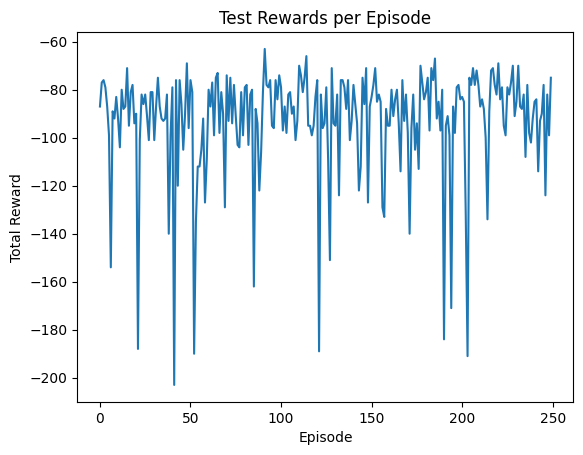

In [11]:
from tqdm import tqdm
from matplotlib import pyplot as plt

env = gym.make("Acrobot-v1")
episodes_record = []
for episode in tqdm(range(250)):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = agent.select_action(obs)
        obs, reward, term, trunc, _ = env.step(action)
        done = term or trunc
        total_reward += reward
    episodes_record.append(total_reward)

ax = plt.subplot(1, 1, 1)
ax.plot(range(len(episodes_record)), episodes_record)
ax.set_title("Test Rewards per Episode")
ax.set_xlabel("Episode")
ax.set_ylabel("Total Reward")